# Catégorisez automatiquement des questions - Stack Overflow

#### Objectif: 
Développement d'un système de suggestion de tags via une API pour facilité la recherche aux utilisateurs sur le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.


Dans ce notebook:  
- Vectorisation 
- Entrainement des modèles 

### Sommaire

* [Import](#chapter1)
    * [Librairies](#section_1_1)
    * [Données](#section_1_2)
 
 
* [Les fonctions](#chapter2)
    * [Nettoyage](#section_2_1)
    * [Vectorization](#section_2_2)
    * [Représentation](#section_2_3)


* [Vectorization](#chapter3)
    * [Bag of Word & Tf idf](#section_3_1)
    * [Word Embeddings](#section_3_2)
        * [Word2Vect](#section_3_2_1)
        * [Bert](#section_3_2_2)
        * [USE](#section_3_2_3)  


* [Modélisation](#chapter4)
    * [Non supervisée: Latent Dirichlet Allocation](#section_4_1)
    * [Modélisation supervisée](#section_4_2)


## Import <a class="anchor" id="chapter1"></a>
### Librairies <a class="anchor" id="section_1_1"></a>

In [298]:
# Import des librairies
import numpy as np
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
import time
from time import time

from collections import Counter

from bs4 import BeautifulSoup

# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

# Modélisation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# LDA modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Visualize data
import pyLDAvis
import pyLDAvis.gensim_models


logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [2]:
import tensorflow

In [3]:
#from tensorflow import *

In [4]:
#Word2Vec
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import tensorflow_hub as hub

In [5]:
# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import warnings
warnings.filterwarnings("ignore",category=DepreciationWarning)

In [7]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
False


In [6]:
#pip install tensorflow_hub

### Nos données <a class="anchor" id="section_1_2"></a>

In [8]:
data = pd.read_csv('processed_data.csv')

In [9]:
data = data.drop(['Unnamed: 0'],axis=1)

In [10]:
data.shape 

(24882, 9)

In [11]:
data.head(1)

,CreationDate,Title,Body,Tags,Text,Cleaned_text,body_tokens_count,number_of_tags,top_tags
0,2008-07-31 21:42:52,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,"c#,floating-point,type-conversion,double,decimal",How to convert Decimal to Double in C#?<p>I wa...,convert decimal double want assign variable tr...,16,1,c#


In [12]:
data["Tags"].nunique()

24414

In [344]:
data.shape

(24882, 13)

In [346]:
data = data.head(24600)

In [347]:
data.shape

(24600, 13)

## Fonctions <a class="anchor" id="chapter2"></a>
### Nattoyages <a class="anchor" id="section_2_1"></a>

In [13]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def remove_code(html):
    # parse html content
    soup = BeautifulSoup(html, "html.parser")  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()  
    # return data by retrieving the tag content
    return soup.stripped_strings

def regex(text):
    
    # Remove html tags
    text=re.sub(r"<[^>]*>",' ', text)
    # Remove usernames "@"
    text=re.sub(r'@\S+', ' ', text)
    # Remove hashtags
    text=re.sub(r'#\S+', ' ', text)
    # Remove punctuation
    text=re.sub(r'[^\w\s]', ' ', text)
    # Remove unicode characters
    text = text.encode("ascii", "ignore").decode()
    # Remove irrelevant characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove English contractions
    text = re.sub("\'\w+", '', text)
    # Remove extra spaces
    text = re.sub('\s+', ' ', text)
    # Remove numbers
    text = re.sub(r'\w*\d+\w*', '', text)
    # Remove links
    text = re.sub(r'http*\S+', '', text)
    # Remove whitespace
    text=re.sub(r'^\s*|\s\s*', ' ', text).strip()
    text=text.replace('\n', '')
    
    return text

def remov_duplicates(input):
 
    # split input string separated by space
    input = input.split(" ")
 
    # now create dictionary using counter method
    # which will have strings as key and their
    # frequencies as value
    UniqW = Counter(input)
 
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    
    return s

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                       and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Remove single character
def remove_single_char_func(text, threshold=1):
    threshold = threshold
    words = word_tokenize(text)
    text = ''.join([w for w in words if len(w) > threshold])
    return text

# Lemmatizer (base d'un mot) with NLTK
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


In [301]:
# Lemmatization with Spacy
# Lemmatization = reduction of word to their core root form, their "lemma"
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text =[]
        # iterate for token and docs, for each of the word in the text
        for token in doc:
            if token.pos_ in allowed_postags: # pos = part of speech
                new_text.append(token.lemma_) # lemma_ for the lemmatized form, to append the lemma itself and not the word to reduce the complexity of the text, and by having fewer words in it.
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out) # Pass in a single text 

In [285]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested. 

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

### Préparation pour la vectorization <a class="anchor" id="section_2_2"></a>

In [14]:
# Fonction de preparation du text pour la vectorization bag of word, Tf idf et Word2Vec

def transform_bow_fct(desc_text) :
    text_regex = regex(desc_text.lower())
    text_remove_duplicated = remov_duplicates(text_regex)
    word_tokens = tokenizer_fct(text_remove_duplicated)
    sw = stop_word_filter_fct(word_tokens)
    lem_w = lemma_fct(sw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [19]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    text_regex = regex(desc_text.lower())
    text_remove_duplicated = remov_duplicates(text_regex)
    word_tokens = tokenizer_fct(text_remove_duplicated)
    transf_desc_text = ' '.join(word_tokens)
    return transf_desc_text

### Représentation graphique <a class="anchor" id="section_2_2"></a>

In [305]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des questions par tags')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des questions par clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [16]:
data['Cleaned_text'] = data['Cleaned_text'].astype("string")

In [17]:
data['Text'] = data['Text'].astype("string")

In [20]:
data['sentence_bow'] = data['Text'].apply(lambda x : transform_bow_fct(x))
data['sentence_dl'] = data['Text'].apply(lambda x : transform_dl_fct(x))
data.shape

(24882, 11)

In [21]:
from nltk.tokenize import sent_tokenize, word_tokenize

data['length_bow'] = data['sentence_bow'].apply(lambda x : len(word_tokenize(str(x))))
max_length_bow = data['length_bow'].max()
print("max length bow : ", max_length_bow)

data['length_dl'] = data['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
max_length_dl = data['length_dl'].max()
print("max length dl : ", max_length_dl)

max length bow :  727
max length dl :  860


In [46]:
print(data[data['length_dl']==1076]['sentence_dl'])
data['sentence_dl'][171]

Series([], Name: sentence_dl, dtype: object)


'java net socketexception connection reset i am getting the following error trying to read from a socket m doing readint on that inputstream and this perusing documentation suggests client part of closed in scenario server have access log files it is not closing fact its suggest so does anybody an idea why happening what else check for arise when there are local resources perhaps reaching thresholds do note line setsotimeout just prior reason long story but curious circumstances under which might lead indicated running my ide happened leave stuck breakpoint then noticed exact same errors begin appearing own logs anyway mentioning hopefully red herring'

In [47]:
data['length_text_brut'] = data['Text'].apply(lambda x : len(word_tokenize(str(x))))
max_length_data_brut = data['length_text_brut'].max()
print("max length Text : ", max_length_data_brut)

max length Text :  8053


In [48]:
data['length_cleaned_text'] = data['Cleaned_text'].apply(lambda x : len(word_tokenize(str(x))))
max_length_cleaned_data = data['length_cleaned_text'].max()
print("max length Cleaned_text : ", max_length_cleaned_data)

max length Cleaned_text :  738


## Vectorization <a class="anchor" id="chapter3"></a>
### Bag of word & Tf-idf <a class="anchor" id="section_3_1"></a>

In [348]:
# Derinir X et y

X=data['sentence_bow']
y=data['top_tags']

In [349]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialisation de Countvectorizer() pour BoW et de TfidfVectorizer() pour Tfidf
# Eliminer les mots qui apparaissent dans plus de 60% des documents (max_df = 0.6).
cvect = CountVectorizer(analyzer="word", stop_words='english', max_df=0.6, min_df=0.005)
ctf = TfidfVectorizer(analyzer="word", stop_words='english', max_df=0.6, min_df=0.005)

# Fit&transform modèle
cv_fit = cvect.fit(X)
ctf_fit = ctf.fit(X)

X_BoW = cvect.transform(X)  
X_tfidf = ctf.transform(X)  

In [350]:
print("Shape of y: {}".format(y.shape))
print("Shape of X for the Title&Text in BoW: {}".format(X_BoW.shape))
print("Shape of X for Title&Text in Tf-idf: {}".format(X_tfidf.shape))

Shape of y: (24600,)
Shape of X for the Title&Text in BoW: (24600, 1595)
Shape of X for Title&Text in Tf-idf: (24600, 1595)


In [26]:
full_dense_X_BoW = X_BoW.todense()
full_dense_X_tfidf = X_tfidf.todense()

print("X BoW sparsicity: {:.3f} %"\
      .format(((full_dense_X_BoW > 0).sum()/full_dense_X_BoW.size)*100))
print("X Tf-idf sparsicity: {:.3f} %"\
      .format(((full_dense_X_tfidf > 0).sum()/full_dense_X_tfidf.size)*100))

X BoW sparsicity: 2.325 %
X Tf-idf sparsicity: 2.325 %


In [351]:
l_cat = list(set(data['top_tags']))
print("catégories : ", l_cat)

catégories :  ['objective-c, image', 'javascript, iphone, html', 'c#, asp.net, .net, asp.net-mvc', 'java, android, macos', 'android, unit-testing', 'java, php, javascript', 'c++, c, string', 'ios, objective-c, iphone, image', 'ruby, git', 'java, arrays', 'python, windows, pandas', 'android, ios, swift', 'c#, .net, wpf, windows', 'iphone, ios, objective-c', 'android, git', 'c, shell', 'javascript, node.js, ajax', 'c, linux, macos', 'ruby-on-rails, ruby, macos', 'php, android, mysql', 'javascript, php, jquery', 'java, php, unit-testing', 'java, .net', 'python, django, ajax', 'python, json', 'python, python-3.x, string, pandas', 'ajax, node.js', 'python, pandas, numpy', 'php, javascript, sql, json', 'c#, .net, database', 'database, git', 'ios, swift, iphone, cocoa-touch', 'php, iphone', 'ruby-on-rails, ruby, image', 'objective-c, json', 'javascript, jquery, ajax, unit-testing', 'c++, algorithm', 'iphone, ios, objective-c, string', 'c++, arrays, numpy', 'python, database', 'php, arrays, st

In [352]:
y_cat_num = [(1-l_cat.index(data.iloc[i]['top_tags'])) for i in range(len(data))]

In [353]:
# Multilabel binarizer for targets

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(data['top_tags'].str.split(', '))

print(" Les différent sujets sont: \n{}".format(mlb.classes_))
print('\n')
print("Shape of y_binarized: {}".format(y_binarized.shape))

 Les différent sujets sont: 
['.net' 'ajax' 'algorithm' 'android' 'arrays' 'asp.net' 'asp.net-mvc'
 'bash' 'c' 'c#' 'c++' 'c++11' 'cocoa-touch' 'css' 'database' 'django'
 'git' 'html' 'image' 'ios' 'iphone' 'java' 'javascript' 'jquery' 'json'
 'linux' 'macos' 'multithreading' 'mysql' 'node.js' 'numpy' 'objective-c'
 'pandas' 'performance' 'php' 'python' 'python-3.x' 'r' 'ruby'
 'ruby-on-rails' 'shell' 'spring' 'sql' 'sql-server' 'string' 'swift'
 'unit-testing' 'windows' 'wpf' 'xcode']


Shape of y_binarized: (24600, 50)


In [354]:
df_y_binarized = pd.DataFrame(y_binarized,columns=mlb.classes_)
df_y_binarized

,.net,ajax,algorithm,android,arrays,asp.net,asp.net-mvc,bash,c,c#,...,shell,spring,sql,sql-server,string,swift,unit-testing,windows,wpf,xcode
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24595,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24596,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24597,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
# Create train and test split (30%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (19680, 1595)
X_test shape : (4920, 1595)
y_train shape : (19680, 50)
y_test shape : (4920, 50)


## Words Embeddings <a class="anchor" id="section_3_2"></a>

### Word2Vec <a class="anchor" id="section_3_2_1"></a>

In [ ]:
# Understanding Word Vectors by Allison Parrish: https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469
# The Coding Train: https://www.youtube.com/watch?v=LSS_bos_TPI
# The Semicolon : https://www.youtube.com/watch?v=UqRCEmrv1gQ

In [122]:
# Prepare inputs for embedding
corpus = data['sentence_bow'].values.tolist()
tokenized_corpus = [nltk.word_tokenize(sent) for sent in corpus]

In [113]:
max_length_bow

727

In [137]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = max_length_bow # adapt to length of sentences

In [139]:
# Création et entraînement du modèle Word2Vec

print("Modèle Word2Vec:")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, # Ignore words that appear less than this
                                   window=w2v_window,       # Context window for words during training
                                   vector_size=w2v_size,    # Dimensionality of word embeddings
                                   seed=42,
                                   sg = 1,                  # skipgrams
                                   workers=1)

t = time()
workers=multiprocessing.cpu_count() # Count the number of cores in a computer
w2v_model.build_vocab(tokenized_corpus)
w2v_model.train(tokenized_corpus, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Modèle Word2Vec:
Vocabulary size: 90672
Word2Vec trained
Time to build vocab: 25.26 mins
Time to train the model: 25.26 mins


In [129]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [140]:
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print(len(w2v_words))

90672


In [141]:
w2v_model.wv.most_similar('code')

[('userview', 0.40419331192970276),
 ('cartopy', 0.4027804136276245),
 ('mypoint', 0.3994652032852173),
 ('fileversioninfo', 0.38931283354759216),
 ('ibdesignable', 0.3852353096008301),
 ('greeterfactory', 0.38003212213516235),
 ('adminportal', 0.3781808912754059),
 ('testbasicexample', 0.3759894371032715),
 ('bootloaders', 0.37546539306640625),
 ('mappingcontroller', 0.3734259009361267)]

In [142]:
w2v_model.wv.most_similar('function')

[('updatebtn', 0.4143073260784149),
 ('ajaxspl', 0.41069623827934265),
 ('shortfunctionsecond', 0.4080568850040436),
 ('ajaxurl', 0.4056723415851593),
 ('iable', 0.40454310178756714),
 ('printcontents', 0.4025193154811859),
 ('printdiv', 0.40204328298568726),
 ('putimage', 0.40134596824645996),
 ('valbox', 0.3997775912284851),
 ('functionproxy', 0.3974323868751526)]

In [143]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_corpus)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(tokenized_corpus),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 90673


In [154]:
from collections import defaultdict  # For word frequency
word_freq = defaultdict(int)
for s in tokenized_corpus:
    for i in s:
        word_freq[i] += 1
        
len(word_freq)

90672

In [155]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['using', 'like', 'use', 'get', 'code', 'way', 'work', 'want', 'would', 'file']

In [150]:
tokenizer.word_index

{'using': 1,
 'like': 2,
 'use': 3,
 'get': 4,
 'code': 5,
 'way': 6,
 'work': 7,
 'want': 8,
 'would': 9,
 'file': 10,
 'one': 11,
 'need': 12,
 'new': 13,
 'know': 14,
 'class': 15,
 'example': 16,
 'return': 17,
 'error': 18,
 'question': 19,
 'data': 20,
 'problem': 21,
 'method': 22,
 'user': 23,
 'following': 24,
 'function': 25,
 'also': 26,
 'make': 27,
 'value': 28,
 'time': 29,
 'application': 30,
 'set': 31,
 'trying': 32,
 'string': 33,
 'type': 34,
 'name': 35,
 'object': 36,
 'something': 37,
 'app': 38,
 'tried': 39,
 'find': 40,
 'run': 41,
 'could': 42,
 'create': 43,
 'see': 44,
 'however': 45,
 'add': 46,
 'found': 47,
 'used': 48,
 'com': 49,
 'server': 50,
 'help': 51,
 'call': 52,
 'result': 53,
 'solution': 54,
 'possible': 55,
 'project': 56,
 'first': 57,
 'change': 58,
 'version': 59,
 'public': 60,
 'test': 61,
 'seems': 62,
 'working': 63,
 'two': 64,
 'line': 65,
 'thanks': 66,
 'without': 67,
 'look': 68,
 'case': 69,
 'list': 70,
 'update': 71,
 'read': 7

In [157]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (90673, 300)


In [158]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')

word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)

word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 727)]             0         
                                                                 
 embedding (Embedding)       (None, 727, 300)          27201900  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 27,201,900
Trainable params: 27,201,900
Non-trainable params: 0
_________________________________________________________________


In [159]:
# Exécution du modèle
embeddings = embed_model.predict(x_sentences)
embeddings.shape

778/778 [==============================] - 2s 3ms/step


(24882, 300)

In [306]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.0068 time :  652.0


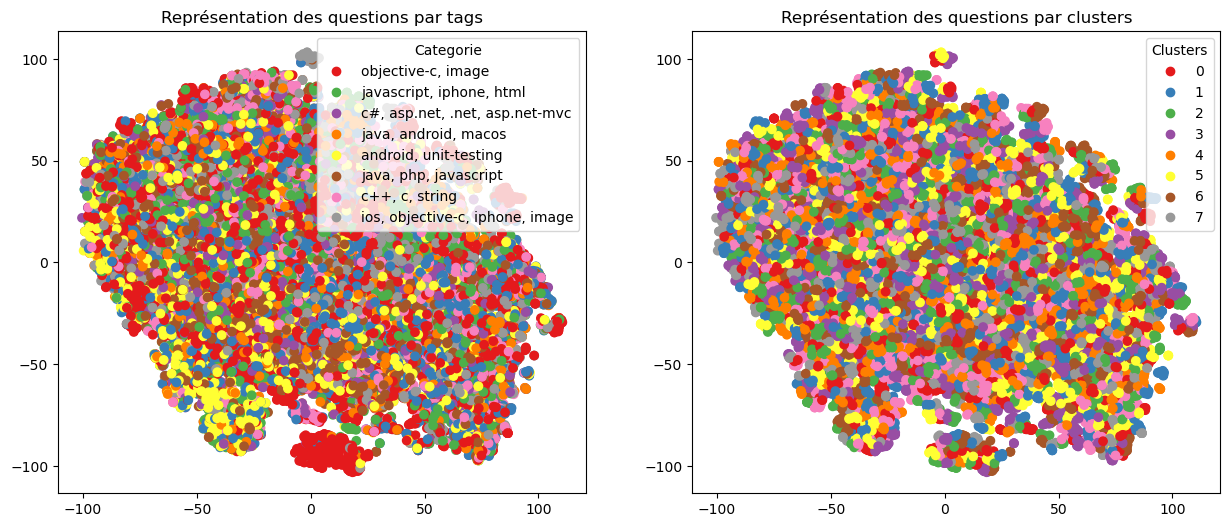

ARI :  0.0068


In [307]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### ACP

In [ ]:
X = numpy.array(embeddings)

### BERT <a class="anchor" id="section_3_2_2"></a>

#### Les Fonctions

In [337]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### BERT HuggingFace

In [35]:
#pip install --upgrade torch torchvision

In [362]:
max_length = 64
batch_size = 600
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type,from_pt=True)

In [357]:
len(data['sentence_dl'])

24600

In [361]:
len(sentences)

24600

In [359]:
sentences = data['sentence_dl'].to_list()

In [363]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 61s 61s/step
temps traitement :  3186.0


In [364]:
features_bert.shape

(24600, 768)

In [365]:
len(y_cat_num,)

24600

In [366]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.0022 time :  5943.0


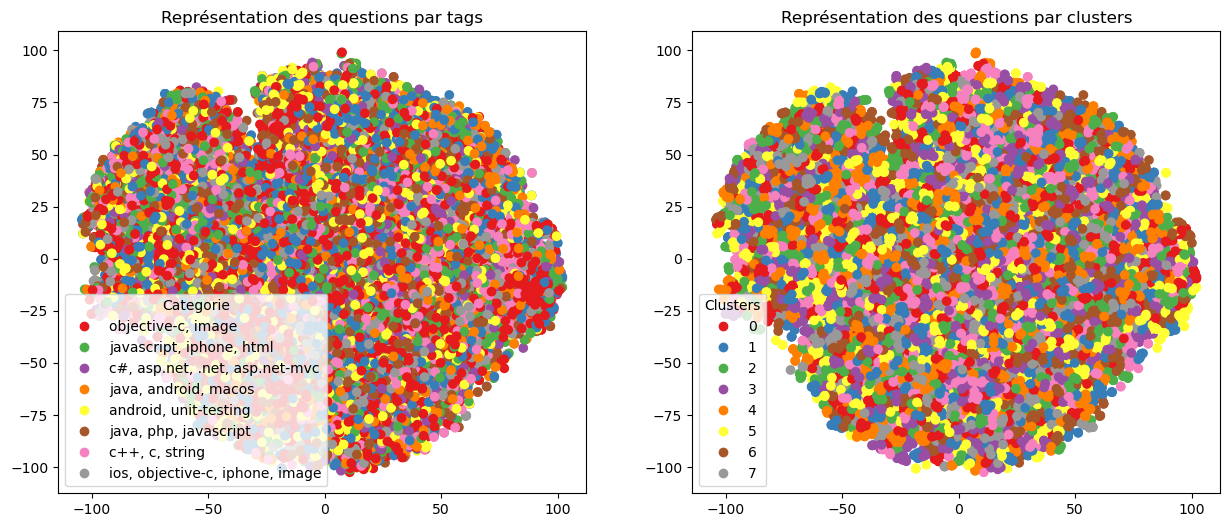

ARI :  0.0022


In [367]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Universal Sentence Encoder <a class="anchor" id="section_3_2_3"></a>

In [315]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [316]:
# Fonction
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time() - time1,0)
    return features

In [368]:
batch_size = 600
sentences = data['sentence_dl'].to_list()

In [369]:
features_USE = feature_USE_fct(sentences, batch_size)

In [370]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.0133 time :  827.0


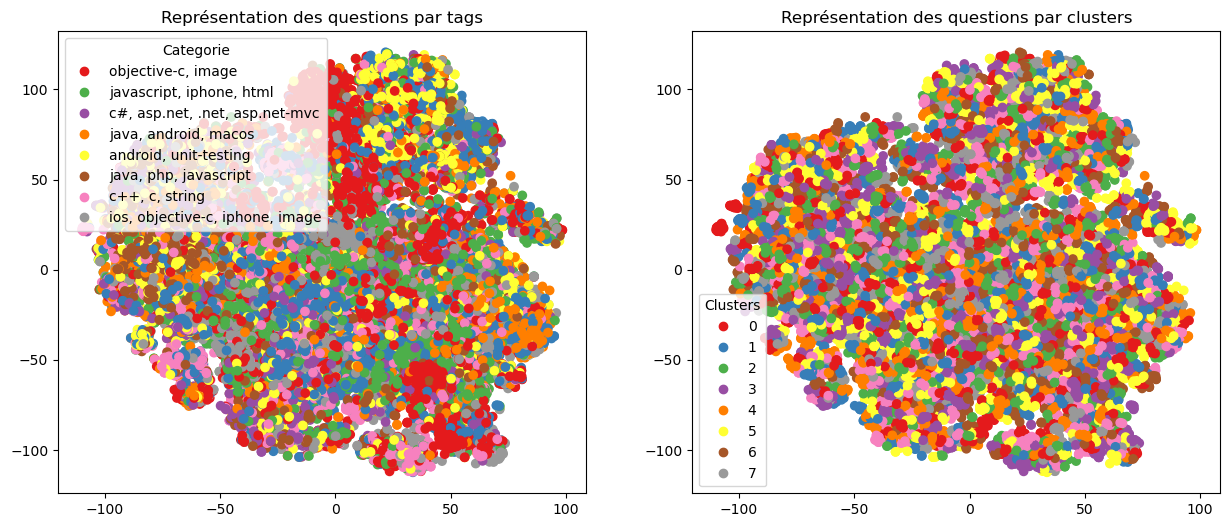

ARI :  0.0133


In [371]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Modélisation <a class="anchor" id="chapter4"></a>
### Non-supervisée: Latent Dirichlet Allocation <a class="anchor" id="section_4_1"></a>

In [84]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Visualize data
from pyLDAvis._display import *
import pyLDAvis
import pyLDAvis.gensim_models


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(full_lda_model, corpus, id2word, mds="mds", R=30);

#### Prepare the text for the model : lemmatize with Spacy & remove stopwords

In [60]:
# To reduce the text to individual words and remove stopwords
def gen_words(texts):
    final = []
    for text in texts: # iterate over all the text
        new = genism.utils.simple_preprocess(text, deacc=True) # deac stands for d accent, it's a boolean true or false, by default it's false. We make it true to make sure that if we have words with accent, they will still be normalized to reduce the complexity of the model
        final.append(new)
    return (final)

In [299]:
data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

NameError: name 'lemmatized_texts' is not defined

In [50]:
# Create id to word dictionnary
id2word = corpora.Dictionary(data_words) # Go to the Gensim library, to allow us to have a few difference pieces of data

corpus = [] # Create an empty list
for text in data_words: # Iterate over each of the texts  
    new = id2word.doc2bow(text) # Create a bag of words that contains a list of unique words and their frequency in the corpus
    corpus.append(new)
    
print (corpus[0][0:20]) # Grab the 20 first characters from the first doc


NameError: name 'data_words' is not defined

#### Prétraitement

In [51]:
X = data['sentence_bow']
y = data["top_tags"]

In [52]:
sentences = data['sentence_bow'].to_list()
sentences

['convert decimal double want assign variable quot trans opacity trackbar value build app give following error implicitly type',
 'calculate relative time given specific datetime value display like hour ago day month',
 'determine user timezone standard way web server able within page perhaps header part agent string',
 'fastest way get value looking obtain personal challenge specifically using way involve constant like hard coding number program test various know inline assembly version theory option though clearly portable included baseline compare version built in atan gcc auto fold constant fno builtin specified main testing pitimes math stdio time iters testwith diff clock printf diffclock static double return clock per sec int warmup case catch folding would optimise used defined gnuc amp amd extern fldpi actual start acos asin stuff work system asm build script build configuration wall ffast apart compiler flag compared bit optimization different also tried switching order aroun

In [53]:
corpus = X.values.tolist()
X = [nltk.word_tokenize(sent) for sent in corpus]

In [54]:
# Create dictionnary (bag of words)

id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)

# Create Corpus 
texts = X 

# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  

# View 
print(corpus[:1]) # to view the index from each word in the Gensim dictionnary

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [55]:
word = id2word[[0][:1][0]]
print (word)

app


In [56]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('app', 1),
  ('assign', 1),
  ('build', 1),
  ('convert', 1),
  ('decimal', 1),
  ('double', 1),
  ('error', 1),
  ('following', 1),
  ('give', 1),
  ('implicitly', 1),
  ('opacity', 1),
  ('quot', 1),
  ('trans', 1),
  ('type', 1),
  ('value', 1),
  ('variable', 1),
  ('want', 1)]]

In [57]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [58]:
# Iter LDA for best number of topics
from time import time
import time

coherence_test = []
for k in np.arange(1,50,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


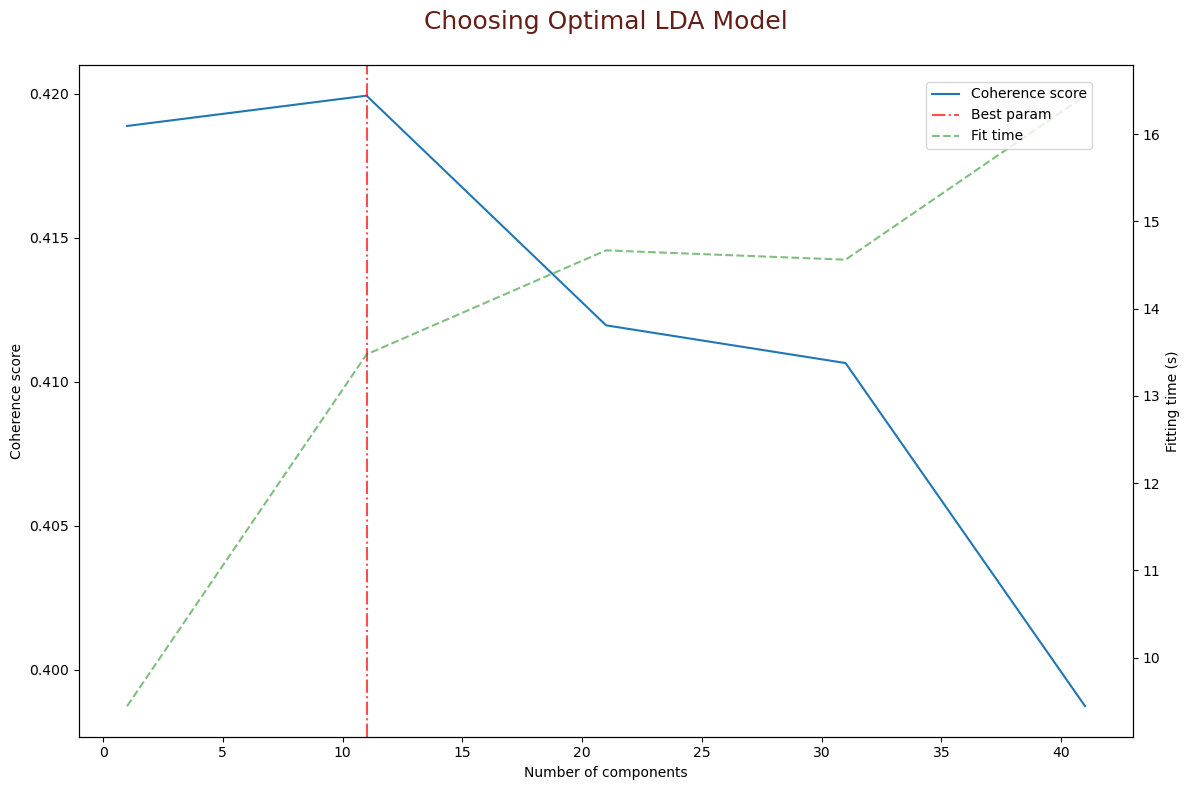

In [59]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()
plt.savefig("Choosing Optimal LDA Model\n",transparent=True)

In [88]:
best_nb_topics

11

In [295]:
lda_opt = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=11,
                                  random_state=8,  
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', lda_opt.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_opt, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Process SpawnPoolWorker-142:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-146:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-147:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-148:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-149:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-150:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-151:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-152:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-153:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Process SpawnPoolWorker-154:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/opt/anaconda3/envs/Projet5/lib/py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Process SpawnPoolWorker-158:
Process SpawnPoolWorker-156:
Process SpawnPoolWorker-155:
Process SpawnPoolWorker-157:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/opt/anaconda3/envs/Projet5/lib/python3.9/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/opt/anaconda3/e

In [ ]:
gensimvis.prepare(lda_opt, corpus, id2word)

In [62]:
# Création du modèle LDA
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 11

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
#lda.fit(data[''])

In [291]:
tf_feature_names = cvect.get_feature_names()
#tf_feature_names

In [ ]:
# Création du modèle LDA
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 11

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
#lda.fit(data[''])


gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)

In [289]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_opt, tf_feature_names, no_top_words)

AttributeError: 'LdaMulticore' object has no attribute 'components_'

#### Vizualizing data

In [ ]:
full_lda_model

In [104]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_opt, corpus, id2word, mds="mds", R=10)

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/setuptools/_distutils/vers

In [105]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.002590 -0.006910       1        1  15.049936
0      0.007102 -0.015582       2        1  14.566410
8     -0.003333 -0.005714       3        1  11.806089
5     -0.003969  0.013458       4        1  11.089806
10    -0.022357  0.011288       5        1   8.989577
4      0.005776 -0.010437       6        1   8.802603
2     -0.038362 -0.003603       7        1   7.337465
1      0.011891  0.008610       8        1   6.140616
3      0.022521 -0.010418       9        1   5.947893
9      0.016223  0.032523      10        1   5.650129
6      0.007098 -0.013214      11        1   4.619475, topic_info=          Term         Freq        Total Category  logprob  loglift
9005     swift   449.000000   449.000000  Default  10.0000  10.0000
84         get  7998.000000  7998.000000  Default   9.0000   9.0000
249       file  6413.000000  6413.000000  Default   8.0000   8.0000
746      class  5004.000000  5004.000000  Default   7.0000   7.0000
232        use  8166.000000  8166.000000  Default   6.0000   6.0000
...        ...          ...          ...      ...      ...      ...
84         get   371.065165  7998.963940  Topic11  -5.1494   0.0042
303   function   256.963624  4212.993871  Topic11  -5.5168   0.2779
41         way   310.721308  7113.442628  Topic11  -5.3269  -0.0560
243       code   313.794617  7801.814976  Topic11  -5.3170  -0.1385
132      would   287.249475  6613.731252  Topic11  -5.4054  -0.0617

[359 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
11909      1  0.665786      aboutus
11443      1  0.045722  accesstoken
11443      2  0.045722  accesstoken
11443      3  0.045722  accesstoken
11443      4  0.045722  accesstoken
...      ...       ...          ...
4195       7  0.106697         yyyy
4195       8  0.015242         yyyy
4195       9  0.030485         yyyy
4195      10  0.015242         yyyy
4195      11  0.030485         yyyy

[1622 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 9, 6, 11, 5, 3, 2, 4, 10, 7])

### Supervisée: Régression logistique avec variable y multi-labels <a class="anchor" id="section_4_2"></a>

In [170]:
from sklearn.model_selection import GridSearchCV

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Performance metric
from sklearn.metrics import f1_score

In [221]:
# Derinir X et y

X=data['sentence_bow']
y=data['top_tags']

In [227]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()

# Fit transform y target
y_mlb = multilabel_binarizer.fit_transform(y.str.split(', '))

In [222]:
y_binarized.shape

(24882, 50)

In [223]:
y.shape

(24882,)

In [228]:
y_mlb.shape

(24882, 50)

In [229]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_mlb,
                                                    test_size=0.2, random_state=8)

print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (19905,)
X_test shape : (4977,)
y_train shape : (19905, 50)
y_test shape : (4977, 50)


In [ ]:
# Pour ce modèle nous allons utilisé le TF-IDF features

In [230]:
# Initialisation de TfidfVectorizer() pour Tfidf
tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english', max_df=0.8, min_df=0.005, max_features=10000)

# Création des TF-IDF features
Xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train)  
Xval_tfidf = tfidf_vectorizer.transform(X_test)

In [171]:
# Nous allons utilisé le OneVsRestClassifier pour resoudre le probleme de Binary Relevance afin de pouvoir faire la modelisation logistic

In [231]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [232]:
# fit model on train data
clf.fit(Xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [233]:
# make predictions for validation set
y_pred = clf.predict(Xval_tfidf)
y_pred.shape

(4977, 50)

In [234]:
y_pred[13]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [270]:
multilabel_binarizer.inverse_transform(y_pred)[13]

('javascript', 'jquery')

In [237]:
#####################################

In [277]:
# Initialize Logistic Regression with OneVsRest

param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]
              }


multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring='f1_weighted',
                              return_train_score = True,
                              refit=True
                             )

In [278]:
multi_logit_cv.fit(Xtrain_tfidf, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [279]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)

print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [280]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,27.448357,1.223174,0.067824,0.025862,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.615306,...,0.609555,0.006698,1,0.892819,0.894088,0.891036,0.892895,0.889639,0.892096,0.001568


In [283]:
# Predict avec Xval
y_test_predicted_labels_tfidf = multi_logit_cv.predict(Xval_tfidf)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('django', 'python'), ('asp.net', 'html'), ('swift',), ('php',)]
True: [('java',), ('django', 'python'), ('php',), ('ios',), ('windows',)]


In [288]:
df_metrics_compare = metrics_score("Logit", df=None,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

,Logit
Accuracy,0.302994
F1,0.627020
Jaccard,0.468231
Recall,0.572344
Precision,0.676134
